In [1]:
import hoomd
import hoomd.md

In [2]:
hoomd.context.initialize("");

HOOMD-blue v2.3.0 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 
Compiled: 04/25/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): NVIDIA driver not installed or is too old, ignoring any GPUs in the system.
HOOMD-blue is running on the CPU


In [3]:
snapshot = hoomd.data.make_snapshot(N=10,
                                    box=hoomd.data.boxdim(Lx=10, Ly=0.5, Lz=0.5),
                                    particle_types=['A', 'B'],
                                    bond_types=['polymer']);

In [4]:
snapshot.particles.position[:] = [[-4.5, 0, 0], [-3.5, 0, 0],
                                  [-2.5, 0, 0], [-1.5, 0, 0],
                                  [-0.5, 0, 0], [0.5, 0, 0],
                                  [1.5, 0, 0], [2.5, 0, 0],
                                  [3.5, 0, 0], [4.5, 0, 0]];

In [5]:
snapshot.particles.typeid[0:7]=0;
snapshot.particles.typeid[7:10]=1;

In [7]:
snapshot.bonds.resize(9);
snapshot.bonds.group[:] = [[0,1], [1, 2], [2,3],
                           [3,4], [4,5], [5,6],
                           [6,7], [7,8], [8,9]];

In [8]:
snapshot.replicate(1,20,20);

In [9]:
import numpy
snapshot.particles.velocity[:] = numpy.random.normal(0.0,
  numpy.sqrt(0.8 / 1.0), [snapshot.particles.N, 3]);

In [10]:
hoomd.init.read_snapshot(snapshot);

notice(2): Group "all" created containing 4000 particles


In [11]:
nl = hoomd.md.nlist.cell();

In [12]:
dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=0.8, seed=1);

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----


In [13]:
dpd.pair_coeff.set('A', 'A', A=25.0, gamma = 1.0);
dpd.pair_coeff.set('A', 'B', A=100.0, gamma = 1.0);
dpd.pair_coeff.set('B', 'B', A=25.0, gamma = 1.0);

In [14]:
nl.reset_exclusions(exclusions = []);

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no


In [15]:
harmonic = hoomd.md.bond.harmonic();

In [16]:
harmonic.bond_coeff.set('polymer', k=100.0, r0=0);

In [17]:
hoomd.md.integrate.mode_standard(dt=0.01);

In [18]:
all = hoomd.group.all();
hoomd.md.integrate.nve(group=all);

In [19]:
hoomd.analyze.log(filename="log-output.log",
                  quantities=['potential_energy', 'temperature'],
                  period=500,
                  overwrite=True);

In [20]:
hoomd.dump.gsd("trajectory.gsd", period=10e3, group=all, overwrite=True);

In [21]:
hoomd.run(5e4);

** starting run **
Time 00:03:05 | Step 176 / 50000 | TPS 17.5936 | ETA 00:47:11
Time 00:03:15 | Step 473 / 50000 | TPS 29.6688 | ETA 00:27:49
Time 00:03:25 | Step 864 / 50000 | TPS 39.0611 | ETA 00:20:57
Time 00:03:35 | Step 1312 / 50000 | TPS 44.7409 | ETA 00:18:08
Time 00:03:45 | Step 1781 / 50000 | TPS 46.8516 | ETA 00:17:09
Time 00:03:55 | Step 2247 / 50000 | TPS 46.5429 | ETA 00:17:05
Time 00:04:05 | Step 2716 / 50000 | TPS 46.8417 | ETA 00:16:49
Time 00:04:15 | Step 3183 / 50000 | TPS 46.6035 | ETA 00:16:44
Time 00:04:25 | Step 3652 / 50000 | TPS 46.7434 | ETA 00:16:31
Time 00:04:35 | Step 4121 / 50000 | TPS 46.8609 | ETA 00:16:19
Time 00:04:45 | Step 4592 / 50000 | TPS 46.9398 | ETA 00:16:07
Time 00:04:55 | Step 5061 / 50000 | TPS 46.8945 | ETA 00:15:58
Time 00:05:05 | Step 5534 / 50000 | TPS 47.2976 | ETA 00:15:40
Time 00:05:15 | Step 6006 / 50000 | TPS 47.1573 | ETA 00:15:32
Time 00:05:25 | Step 6477 / 50000 | TPS 47.0088 | ETA 00:15:25
Time 00:05:35 | Step 6950 / 50000 | TPS

In [22]:
import numpy
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);

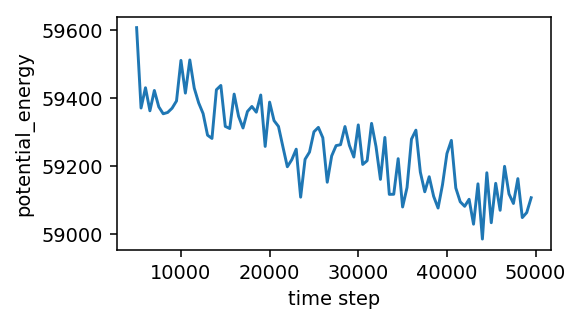

In [23]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[10:,0], data[10:,1]);
pyplot.xlabel('time step');
pyplot.ylabel('potential_energy');

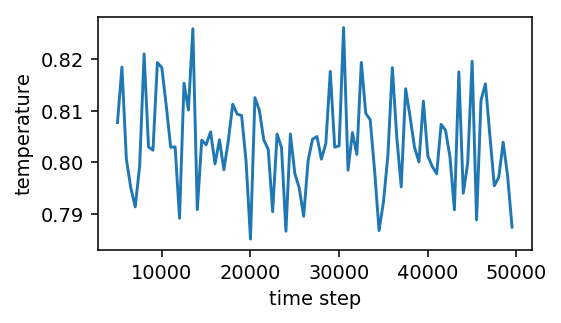

In [24]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[10:,0], data[10:,2]);
pyplot.xlabel('time step');
pyplot.ylabel('temperature');

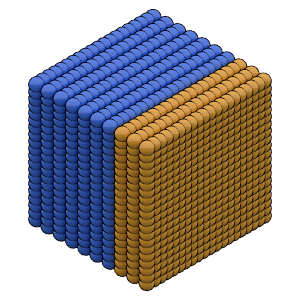

In [26]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory.gsd');